In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision import datasets, transforms
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from omegaconf import OmegaConf, DictConfig
from cv.utils.config import parse_config
import torch
from cv.utils.build import build_model
from torchvision.transforms import v2
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from cv.data.cifar100 import CLASSES


%config InlineBackend.figure_formats = ['retina']

In [4]:
DATA_DIR = Path("/raid4/datasets")

In [5]:
train_dataset = datasets.CIFAR100(root=DATA_DIR, train=True)

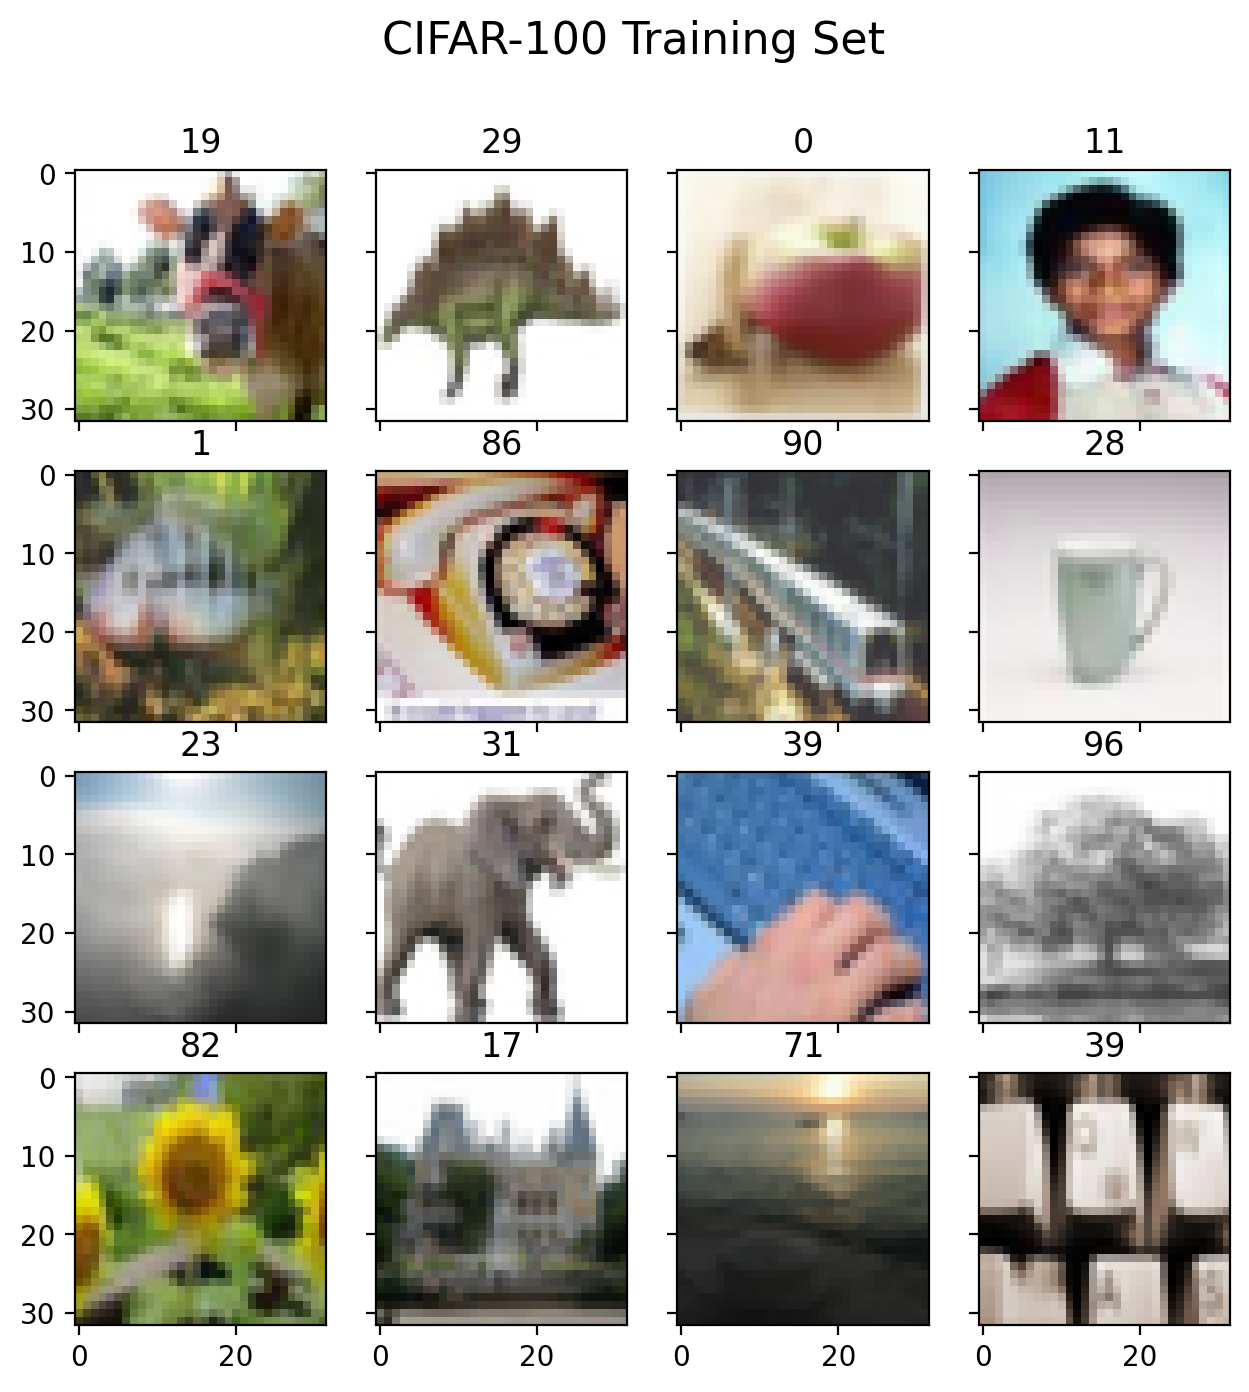

In [6]:
fig = plt.figure(figsize=(7.5, 7.5))
grid = ImageGrid(
    fig,
    111,  # similar to subplot(111)
    nrows_ncols=(4, 4),  # creates 2x2 grid of Axes
    axes_pad=0.25,  # pad between Axes in inch.
)
fig.suptitle("CIFAR-100 Training Set", fontsize=16)

for i, ax in enumerate(grid):
    image, label = train_dataset[i]
    ax.imshow(image)
    ax.set_title(label)


In [7]:
ood_dataset = np.load(DATA_DIR.joinpath("cifar-100-ood", "distortion00.npy"))

In [8]:
idx = [9999, 19999, 29999, 39999, 49999]

In [9]:
ood_sample_dataset = ood_dataset[idx]

In [10]:
ood_sample_dataset.shape

(5, 32, 32, 3)

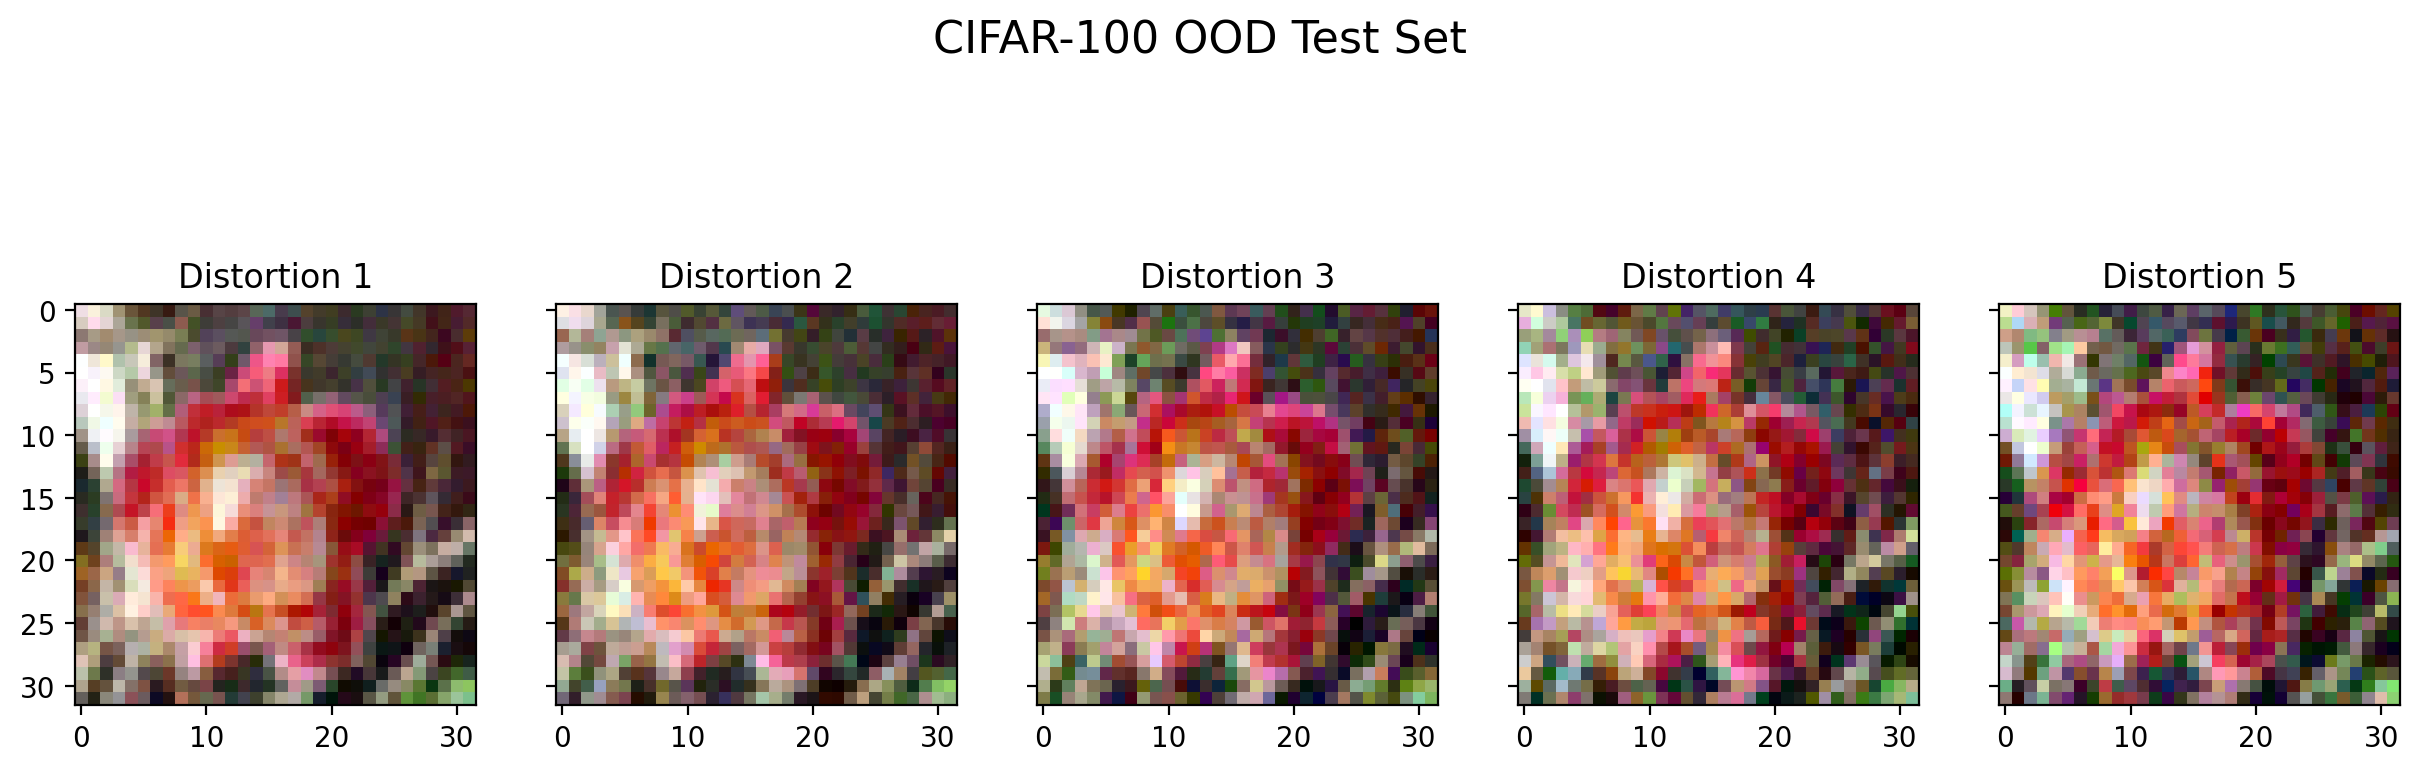

In [11]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5), sharey=True, sharex=True)

fig.suptitle("CIFAR-100 OOD Test Set", fontsize=16)

for i, ax in enumerate(axs.ravel()):
    image = ood_sample_dataset[i]
    ax.imshow(image)
    ax.set_title(f"Distortion {i + 1}")


In [12]:
base_config_path = Path("../config")

config = parse_config(
    base_config_path.joinpath("inference.yml"),
    base_config_path.joinpath("models", "convnet.yml"),
    base_config_path.joinpath("wandb.yml"),
)

In [13]:
config.ckpt_path = Path("../outputs/part1/best_model.pth")

In [14]:
model = build_model(config).to(config.device)

state_dict = torch.load(config.ckpt_path, weights_only=False)

model.load_state_dict(state_dict["model"])

for param in model.parameters():
    param.requires_grad = False

model.eval()

ConvNet(
  (conv_blocks): Sequential(
    (0): ConvBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout(p=0.25, inplace=False)
    )
    (1): ConvBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [15]:
transform_test = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
    ]
)

In [16]:
with torch.inference_mode():
    for i in range(ood_sample_dataset.shape[0]):
        inp = transform_test(ood_sample_dataset[i])
        inp = inp.unsqueeze_(0).to(config.device)
        pred = model(inp)
        pred = pred.softmax(dim=-1)
        print(pred.topk(k=5))
        pred = pred.argmax(dim=-1)
        pred = pred.cpu().item()
        print(CLASSES[pred])

torch.return_types.topk(
values=tensor([[1.0000e+00, 9.4028e-07, 6.2886e-07, 9.7815e-08, 1.8747e-08]],
       device='cuda:0'),
indices=tensor([[70, 92, 62, 54, 35]], device='cuda:0'))
rose
torch.return_types.topk(
values=tensor([[9.9999e-01, 4.3509e-06, 4.5065e-07, 3.2682e-07, 2.1705e-07]],
       device='cuda:0'),
indices=tensor([[70, 62, 92, 54, 26]], device='cuda:0'))
rose
torch.return_types.topk(
values=tensor([[9.9991e-01, 6.4146e-05, 1.2743e-05, 8.0099e-06, 1.1439e-06]],
       device='cuda:0'),
indices=tensor([[70, 26, 45, 61, 62]], device='cuda:0'))
rose
torch.return_types.topk(
values=tensor([[9.9978e-01, 3.9044e-05, 3.0809e-05, 2.9390e-05, 2.0155e-05]],
       device='cuda:0'),
indices=tensor([[70, 33, 62, 26, 47]], device='cuda:0'))
rose
torch.return_types.topk(
values=tensor([[9.8961e-01, 9.2178e-03, 5.0977e-04, 1.5692e-04, 1.3787e-04]],
       device='cuda:0'),
indices=tensor([[70, 26, 61, 10, 33]], device='cuda:0'))
rose
